# Great Energy Predictor - Exploratory Data Analysis
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and Data

### Dependencies

In [2]:
import gc
import os
import zipfile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as udf

In [ ]:
# Plot styles
mpl.style.available

In [ ]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (15, 3)
mpl.rcParams['font.size'] = 12

### Create data directory

In [ ]:
# Create raw data directory
data_path = os.path.join('..', 'data', 'raw')
os.makedirs(data_path, exist_ok=True)

### Download data from Kaggle

##### Download manually
1. Create a Kaggle account [here](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F)
2. Download the data manually [here](https://www.kaggle.com/c/ashrae-energy-prediction/data)
3. Unzip the .zip file and move all extracted files into the `data/raw/` directory created in the code cell above

##### Download programatically
1. Create a Kaggle account [here](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F)
2. Navigate to `Account` in the menu and scroll down to `API`
3. Click `Create New API Token` - this downloads a json file called `kaggle.json` that contains the API credentials
4. Uncomment and run the code cell below (may take a while to run)

Source: https://github.com/Kaggle/kaggle-api

In [ ]:
# Install Kaggle API (or install with pip)
# !conda install kaggle --y

# # Move Kaggle credentials into ~/.kaggle/
# !mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json

# # Remove read permission for other users
# !chmod 600 ~/.kaggle/kaggle.json

# # Download zipped data from Kaggle
# !kaggle competitions download -c ashrae-energy-prediction

# # Unzip the data into the raw data directory
# zip_file = 'ashrae-energy-prediction.zip'
# with zipfile.ZipFile(zip_file, 'r') as f:
#     f.extractall(data_path)
    
# # Delete zip file
# !rm $zip_file
# del zip_file

### Read data

In [ ]:
# Meter data
meter = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['timestamp'])
meter.info()

In [ ]:
# Reduce memory in meter data
meter = udf.reduce_mem_usage(meter)
meter.info()

In [ ]:
# Weather data
weather = pd.read_csv(os.path.join(data_path, 'weather_train.csv'), parse_dates=['timestamp'])
weather.info()

In [ ]:
# Reduce memory in weather data
weather = udf.reduce_mem_usage(weather)
weather.info()

In [ ]:
# Building data
building = pd.read_csv(os.path.join(data_path, 'building_metadata.csv'))
building.info()

In [ ]:
# Reduce memory in building data
building = udf.reduce_mem_usage(building)
building.info()

In [ ]:
del data_path
gc.collect()

## Section II: Meter EDA

### Convert units for site 0 meter types 0 and 1

The meter readings of meter types 0 and 1 of site 0 were not converted in the meter data. We will be converting all meter 0 (electricity) readings in site 0 to kWh and all meter 1 (chilledwater) readings in site 0 to tons to be consistent with the rest of the data.

Source: https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

In [ ]:
# Add site col to the meter df
meter = pd.merge(meter, building[['site_id', 'building_id']], on='building_id', how='left')

# Positive electric readings in site 0 (in kBTU)
meter[(meter['site_id'] == 0) & (meter['meter'] == 0) & (meter['meter_reading'] > 0)].head(3)

In [ ]:
# Convert site 0 electric readings to kWh: 1 kBTU * 0.2931 = 1kWh
meter = udf.convert_readings(meter, site_num=0, meter_num=0, convert_from='kbtu', convert_to='kwh')
meter[(meter['site_id'] == 0) & (meter['meter'] == 0) & (meter['meter_reading'] > 0)].head(3)

In [ ]:
# Chilled water readings in site 0 (in kBTU)
meter[(meter['site_id'] == 0) & (meter['meter'] == 1)].head(3)

In [ ]:
# Convert site 0 chilled water readings to tons: 1 kBTU/hr * 0.0833 = 1 ton (refridgeration)
meter = udf.convert_readings(meter, site_num=0, meter_num=1, convert_from='kbtu', convert_to='ton')
meter[(meter['site_id'] == 0) & (meter['meter'] == 1)].head(3)

### Duplicated observations and missing values

In [ ]:
# Duplicated observations
meter.duplicated(subset=['building_id', 'meter', 'timestamp']).sum()

In [ ]:
# Missing vals
meter.isnull().sum()

In [ ]:
# Missing timestamps
timestamp_count = meter.groupby(['building_id', 'meter'])['timestamp'].count()
n_meters = timestamp_count.shape[0] # num of different meters in the data
n_timestamps = 366 * 24 # every meter should have this many readings
print('Missing timestamps:', (n_meters * n_timestamps) - meter.shape[0])

In [ ]:
# Summary of missing readings
udf.missing_readings_summary(meter)

### Explore meter readings

In [ ]:
# Distribution of meter readings < 1,000
meter_lt1k = meter[(meter['meter_reading'] > 0) & (meter['meter_reading'] < 1000)]
meter_lt1k['meter_reading'].plot(kind='hist', bins=40, title='Distribution of Meter Readings < 1000')
plt.autoscale(axis='x', tight=True)
plt.show()

In [ ]:
# Check high meter readings (> 1,000,000)
high_readings = meter[meter['meter_reading'] > 1e6]
high_readings.shape[0]

In [ ]:
# Check buildings and meters with high readings
print('Meters with readings > 1,000,000:')
print('Buildings:', high_readings['building_id'].unique())
print('Meters:', high_readings['meter'].unique())

In [ ]:
# Check building 1099 meter 2
b1099m2 = meter[(meter['building_id'] == 1099) & (meter['meter'] == 2)].set_index('timestamp')
b1099m2['meter_reading'].plot(title='Building 1099 Meter 2 (Steam) Readings', 
                              ylabel='Meter reading', xlabel='Time')
plt.show()

In [ ]:
# Check readings < 100,000
b1099m2_lt100k = b1099m2[b1099m2['meter_reading'] < 1e5]['meter_reading']
b1099m2_plot = b1099m2_lt100k.plot(title='Building 1099 Meter 2 (Steam) Readings Less Than 100k',
                                   ylabel='Meter reading', xlabel='Time')

# Formatting
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(b1099m2_plot.get_xticks(), labels[1:], rotation=0, ha='center')
plt.show()

### Outlier meter readings

All of the high readings are coming from meter 2 of building 1099. This could be due to the meter malfunctioning or the data being corrupted but either way, we will be dropping these readings.

In [ ]:
# Set outlier threshold
lower, upper = udf.get_outlier_threshold(meter, 'meter_reading', stat='iqr', multiplier=50)
lower, upper

In [ ]:
# Count outliers based on threshold
outliers = meter[meter['meter_reading'] > upper].shape[0]
print(f'{outliers} outliers ({round(outliers / meter.shape[0] * 100, 2)}%)')

In [ ]:
# Drop outliers
meter = meter[meter['meter_reading'] <= upper].copy()
meter.shape

In [ ]:
del timestamp_count, n_meters, n_timestamps, meter_lt1k, \
    b1099m2, b1099m2_lt100k, b1099m2_plot, labels, \
    high_readings, lower, upper, outliers
gc.collect()

### Explore meter types

In [ ]:
# Add meter type as a str in a new col
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
meter['meter_type'] = meter['meter'].map(meter_types)

# Num of buildings w/ each meter type
meter_type_count = meter.groupby('meter_type')['building_id'].nunique().sort_values()
meter_type_count

In [ ]:
# Num of buildings with each meter type
meter_type_count.plot.barh(title='Number of Buildings with Each Meter Type', 
                           ylabel='Meter', xlabel='Number of buildings')
plt.show()

In [ ]:
# Num of buildings with n meters
meter_count = meter.groupby('building_id')['meter'].nunique().value_counts().sort_values()
meter_count

In [ ]:
# Plot num of buildings with n meters
meter_count.plot.barh(title='Number of Buildings with n Meters', 
                      ylabel='Number of meters in the building (n)', 
                      xlabel='Number of buildings')
plt.show()

In [ ]:
# Num of meter readings from each building
meter.groupby('building_id')['timestamp'].count() \
     .plot(title='Number of Meter Readings from Each Building', 
           ylabel='Number of meter readings', xlabel='Building id')
plt.autoscale(axis='x', tight=True)
plt.show()

##### Meter summary
- Most buildings have only 1 meter type and and only 13 buildings actually have all 4 meter types
- Almost all buildings have an electricity meter, followed by chilledwater, steam, then hotwater (in count)

### Sample meter readings from each meter type

In [ ]:
# List of buildings that have each meter type
meter_groups = [meter[meter['meter'] == m].building_id.unique() for m in range(4)]

# Plot meter readings from 1 of each meter type
udf.plot_readings(meter, meter_groups, resample='d')
plt.show()

The plots show a lot of 0-readings, which are likely missing data. Chilled water meter readings are highest in the summer months, while steam and hot water meter readings are highest in the winter months, which makes sense.

In [ ]:
# Extract time components from timestamp
time_comps = ['dayofyear', 'month', 'day', 'dayofweek', 'hour']
meter = udf.extract_dt_components(meter, time_comps)
meter.head(3)

In [ ]:
# Reduce memory usage for new cols
meter = udf.reduce_mem_usage(meter)
meter.info()

In [ ]:
# Meter readings by weekday
udf.plot_readings(meter, meter_groups, groupby=['dayofweek', 'hour'],
                  start=25, end=26, ticks=range(0, 7 * 24, 12))
plt.show()

##### Daily meter readings
- Readings from all 4 meter types oscillate between day and night
- Electricity meter readings reach their peak around noon and their minimum around midnight
- The low electricity usage in the weekend suggests that building is likely an office or other business that is closed on weekends
- Steam and hot water meter readings reach their peak in the early morning and their minimum in the evening hours
- Chilled water meter readings show an oscillation pattern opposite from steam and hot water meters

In [ ]:
# Meter readings by hr
udf.plot_readings(meter, meter_groups, groupby=['hour'], start=50, end=51, ticks=range(24))
plt.show()

These plots take a closer look at the daily oscillation in meter readings. The patterns are the same as described above.

### Monthly average meter readings of each site

In [ ]:
# Electric meters only
e_meter = meter[meter['meter'] == 0]

# Electric meter readings by site (readings from site 7 are on a greater scale)
udf.pivot_elec_readings(e_meter, pivot_col='site_id', freq='m', 
                        cols_to_sep=[7], add_to_title=' by Site')

In [ ]:
# Check avg building size in site 7
building.groupby('site_id').square_feet.mean()

In [ ]:
del meter_types, meter_type_count, meter_count, meter_groups, time_comps, e_meter
gc.collect()

Site 7 buildings are much larger (greater square footage) on average than all other sites. That could explain some, if not all, of the difference in meter reading scale. This will require more investigation during preprocessing.

## Section III: Weather EDA

### Duplicated observations and missing values

In [ ]:
# Duplicated observations
weather.duplicated(subset=['site_id', 'timestamp']).sum()

In [ ]:
# Missing vals
weather.isnull().sum()

In [ ]:
# Missing timestamps - there should be 140,544 timestamps (16 sites x 366 days x 24 hours)
print('Missing timestamps:', (16 * 366 * 24) - weather.shape[0])

### Explore weather

In [ ]:
# Measurement distributions
udf.hist_subplots(weather, range(2, 9))
plt.show()

##### Weather distributions:
- `Air_temperature` and `sea_level_pressure` are normally distributed
- `Dew_temperature`'s distribution has a similar shape to `air_temperature` but with a slight left skew
- Aside from the absence of wind, `wind_speed` is right-skewed and `wind_direction` is almost uniformly distributed
- `Cloud_coverage` and `precip_depth_1_hr` are mostly 0

In [ ]:
# Daily weather in site 4
weather4 = udf.get_site(weather, 4, time_idx=True).resample('d').mean()
weather4.plot(subplots=True, figsize=(15, 21), xlabel='Timestamp')
plt.suptitle('Average Daily Weather Measurements (Site 4)', y=0.9)
plt.xticks(rotation=0)
plt.show()

##### Daily weather in site 4
- Naturally, `air_temperature` and `dew_temperature` are highest in the summer and and lowest in the winter
- Although `wind_direction` shows the same pattern as the temperature variables, it's a little different in that the units are compass direction (which is not ordinal in nature)
- `Cloud_coverage` and `wind_speed` are relatively constant throughout the year, with slightly stronger winds in the middle of the year
- `Sea_level_pressure` is not only greater in the winter months, but also has higher variance
- Most of the rain occurs between the months of November and January, as well as March

In [ ]:
# Extract hour from timestamp
weather = udf.extract_dt_components(weather, ['hour'])

# Site 8 hourly weather
weather8 = udf.get_site(weather, 8).groupby('hour').mean()
weather8.plot(subplots=True, figsize=(15, 21), xlabel='Hour')
plt.suptitle('Average Hourly Weather Measurements (Site 8)', y='0.9')
plt.autoscale(axis='x', tight=True)
plt.xticks(range(24), rotation=0)
plt.show()

The `air_temperature` peaking at 7 PM is not normal. We will check out the `air_temperature` for all sites to see if there is a difference.

In [ ]:
# Hourly temperature from all sites
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', 
                         values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(15, 5), xticks=range(24), 
             ylabel='Air temperature', xlabel='Hour', 
             title='Average Hourly Temperature by Site')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.autoscale(axis='x', tight=True)
plt.show()

### Convert UTC to local time

The plot above shows that the daily maximum temperature is occurring at different hours in the day at each site, even as late as midnight. Since the hottest time of day is usually between noon and 4PM, the weather data is most likely using UTC time. We will need to convert the data to local time to make it consistent with the meter data.

After a little digging around, the site locations were found to be the following list below. They may not be 100% accurate but the conversions should get us to the correct timezone (or at least close enough).

Sites:
- 0 - Orlando, Florida (GMT-5)
- 1 - United Kingdom (GMT+0)
- 2 - Arizona (GMT-7)
- 3 - U.S. Eastern Time Zone (GMT-5)
- 4 - Northern California (GMT-8)
- 5 - United Kingdom (GMT+0)
- 6 - U.S. Eastern Time Zone (GMT-5)
- 7 - Southeastern Canada (GMT-5)
- 8 - Orlando, Florida (GMT-5)
- 9 - Texas (GMT-6)
- 10 - U.S. Mountain Time Zone (GMT-7)
- 11 - Southeastern Canada (GMT-5)
- 12 - Dublin, Ireland (GMT+0)
- 13 - Minnesota (GMT-6)
- 14 - U.S. Eastern Time Zone (GMT-5)
- 15 - U.S. Eastern Time Zone (GMT-5)

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

In [ ]:
# Offsets for timezones
timezones = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Convert UTC to local time
weather = udf.to_local_time(weather, timezones)
weather['hour'] = weather['timestamp'].dt.hour

# Hourly temperature from all sites
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', 
                         values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(15, 5), xticks=range(24), 
             ylabel='Air temperature', xlabel='Hour',
             title='Hourly air temperature by site')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.autoscale(axis='x', tight=True)
plt.show()

In [ ]:
# Air temperature by site
fig = sns.jointplot(data=weather, x='air_temperature', y='site_id')
fig.fig.suptitle('Temperature Range by Site', y=1.02)
fig.set_axis_labels('Air Temperature', 'Site')
plt.yticks(range(16), range(16))
plt.show()

In [ ]:
del weather4, weather8, airtemp, timezones, fig
gc.collect()

##### Similar temperature ranges:
- Sites 0, 4, 8 - Florida x2, California (coastal states)
- Sites 1, 5, 12 - UK x2, Ireland (European countries)
- Sites 3 and 6 - both U.S. eastern states
- Sites 7, 11, 13 - Southeastern Canada x2, Minnesota (around Canadian border)

These temperature ranges support the locations that were found for each site.

## Section IV: Building EDA

### Duplicated observations and missing values

In [52]:
# Duplicated observations
building.duplicated(subset=['building_id']).sum()

0

In [53]:
# Missing vals
building.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

### Explore buildings

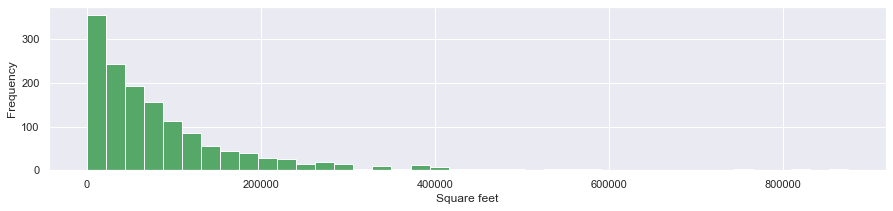

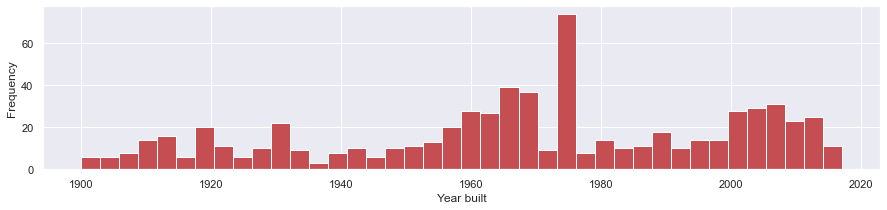

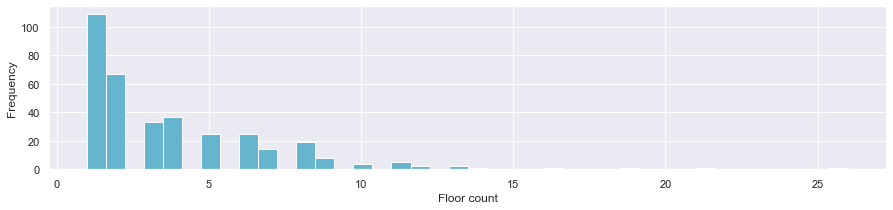

In [54]:
# Value distributions
udf.hist_subplots(building, range(3, 6))
plt.show()

##### Building distributions
- `Square_feet` is highly right-skewed
- `Year_built` shows the most buildings being built between 1960 and 1980, especially in the mid-70s
- Most buildings are missing a `floor_count` so this data is unreliable, but it almost has a similar shape to the `square_feet` distribution
    - Perhaps we can use `square_feet` to estimate missing `floor_count`s

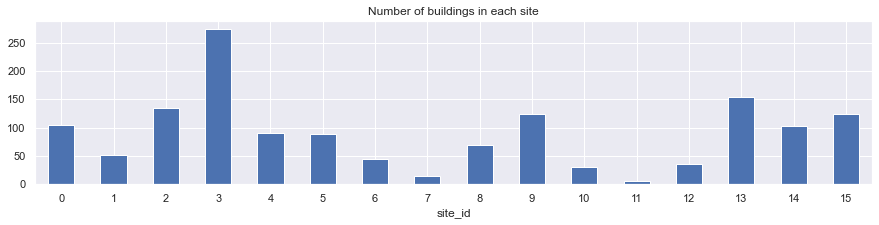

In [55]:
# Number of buildings in each site
building.groupby('site_id').building_id.count().plot.bar(title='Number of buildings in each site')
plt.xticks(rotation=0)
plt.show()

In [56]:
# Average values by site
bldg_avg_by_site = building.drop('building_id', axis=1).groupby('site_id').mean()
bldg_avg_by_site

,square_feet,year_built,floor_count
site_id,,,
0,86394.638095,1995.542847,NaN
1,65002.392157,1961.474976,7.000000
2,99542.214815,1974.882935,NaN
3,75290.383212,1961.727295,NaN
4,92876.241758,1954.123535,5.252747
5,47612.415730,1962.602295,2.280899
6,91857.704545,NaN,NaN
7,323634.533333,1958.500000,8.733334
8,29712.200000,NaN,1.014286


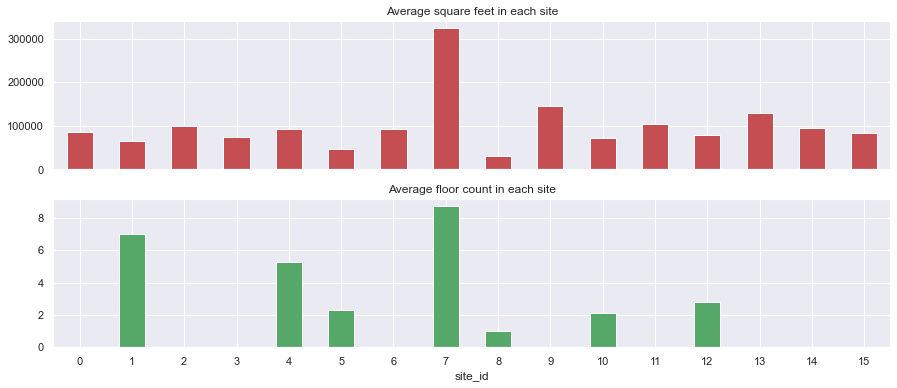

In [57]:
# Plot average square footage and floor count by site
plot_titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]
bldg_avg_by_site.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(15, 6), title=plot_titles,
                                                     legend=False, color=['r', 'g'])
plt.xticks(rotation=0)
plt.show()

Out of the 7 sites that actually have `floor_couunt` data, only 3 sites are showing a similar pattern between `square_feet` and `floor_count` so `square_feet` may not be a good predictor of `floor_count` after all.

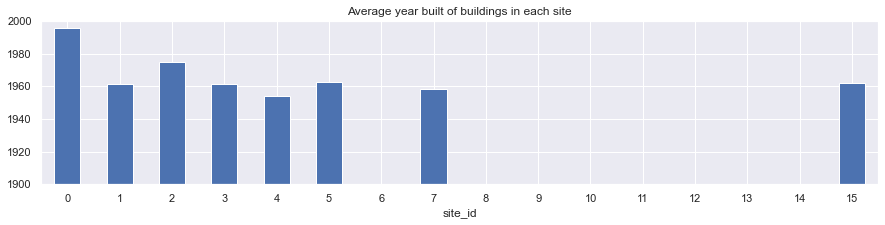

In [58]:
# Plot average year-built by site
bldg_avg_by_site.year_built.plot.bar(title='Average year built of buildings in each site', ylim=(1900, 2000))
plt.xticks(rotation=0)
plt.show()

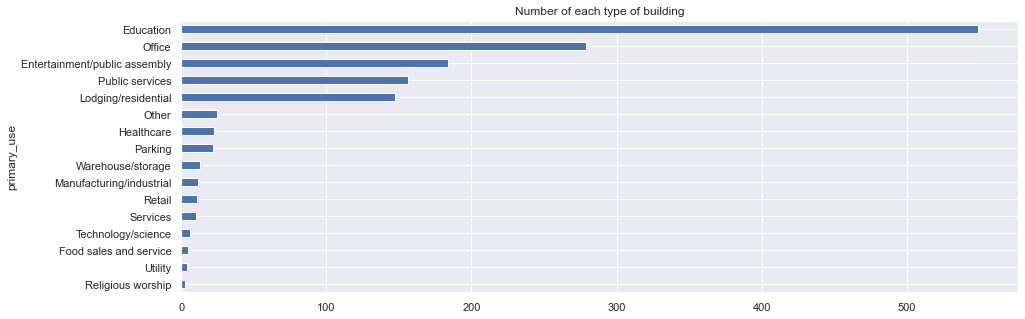

In [59]:
# Number of each type of building
bldg_use_counts = building.groupby('primary_use').building_id.count().sort_values()
bldg_use_counts.plot.barh(figsize=(15, 5), title='Number of each type of building')
plt.show()

Education and office buildings make up more than half of all the buildings in the data. It could be that a lot of the sites are universities or business districts.

In [60]:
# Number of each type of building in each site
bldg_use_by_site = pd.pivot_table(building, index='site_id', columns='primary_use', values='building_id',
                                  aggfunc='count', fill_value=0)
bldg_use_by_site

primary_use,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
site_id,,,,,,,,,,,,,,,,
0,30,5,0,0,27,0,24,5,8,0,0,6,0,0,0,0
1,22,1,0,0,10,0,16,0,0,2,0,0,0,0,0,0
2,61,21,2,1,12,0,24,0,3,6,1,1,0,0,1,2
3,92,44,0,6,11,0,23,4,1,86,1,1,0,0,0,5
4,66,9,0,0,4,0,0,0,3,6,0,0,0,2,1,0
5,49,18,0,1,1,3,11,1,0,5,0,0,0,0,0,0
6,15,4,0,0,12,0,11,0,0,2,0,0,0,0,0,0
7,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,24,0,0,0,0,7,9,0,28,0,0,0,0,0,2


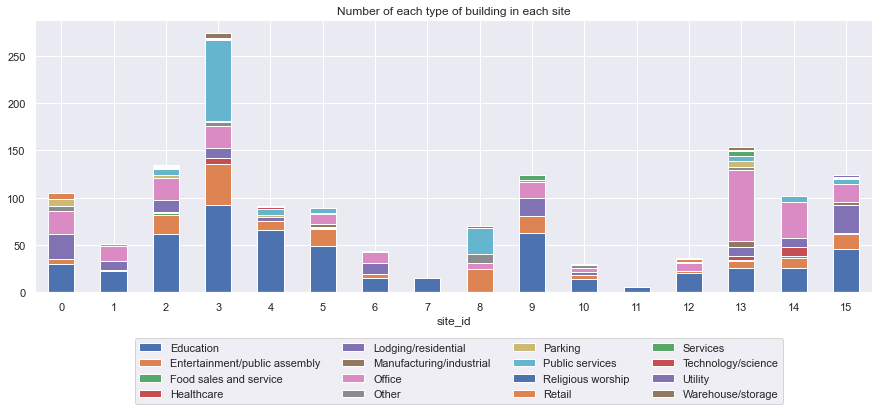

In [61]:
# Plot number of each type of building in each site
bldg_use_by_site.plot.bar(stacked=True, figsize=(15, 5), title='Number of each type of building in each site')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, -0.15), ncol=4, fancybox=True)
plt.show()

Education buildings are a large portion of most of the 16 sites, followed by office buildings. Sites 7 and 11 look to be all education buildings.

In [62]:
# Average values by primary use
bldg_avg_by_use = building.drop(['site_id', 'building_id'], axis=1).groupby('primary_use').mean()
bldg_avg_by_use

,square_feet,year_built,floor_count
primary_use,,,
Education,104329.000000,1962.579712,4.732558
Entertainment/public assembly,80584.070652,1970.904053,2.089286
Food sales and service,38485.000000,2012.000000,NaN
Healthcare,140480.869565,1982.250000,1.000000
Lodging/residential,85368.605442,1973.282349,6.333333
Manufacturing/industrial,41120.833333,1957.666626,1.666667
Office,87065.627240,1972.894165,3.725000
Other,31456.560000,1981.500000,1.076923
Parking,279341.772727,1998.500000,2.666667


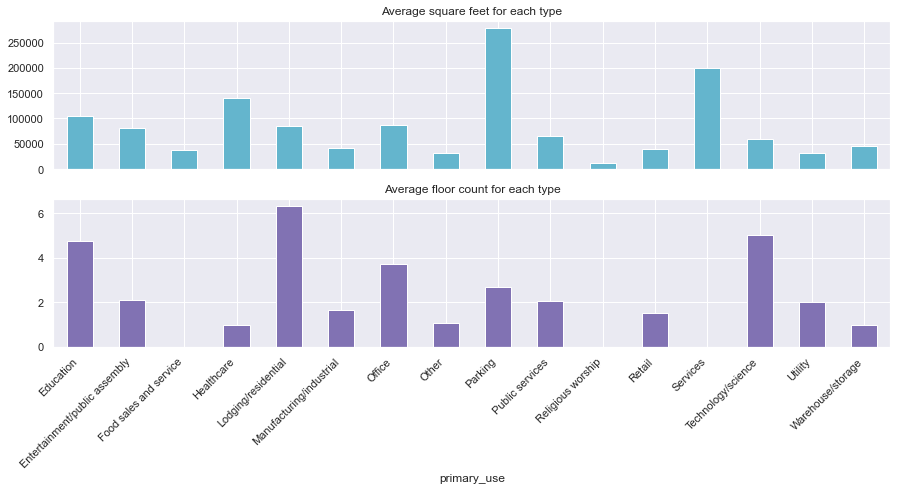

In [63]:
# Subplot titles
plot_titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square footage and floor count by primary use
bldg_avg_by_use.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(15, 6), title=plot_titles,
                                                    legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right')
plt.show()

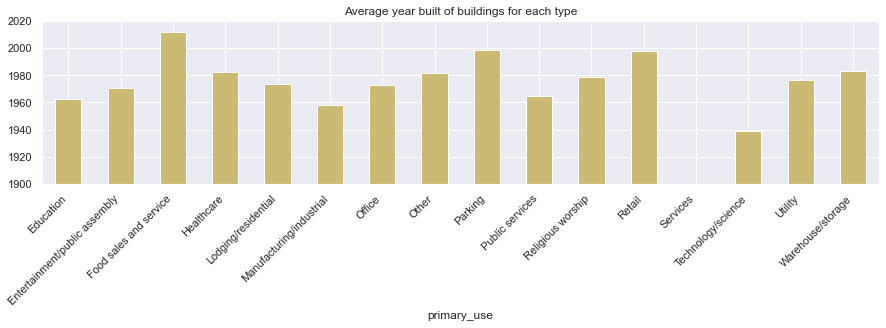

In [64]:
# Average year-built by primary uuse
bldg_avg_by_use.year_built.plot.bar(title='Average year built of buildings for each type',
                                    ylim=(1900, 2020), color='y')
plt.xticks(rotation=45, ha='right')
plt.show()

In [65]:
del bldg_avg_by_site, plot_titles, bldg_use_counts, bldg_use_by_site, bldg_avg_by_use
gc.collect()

38150

##### Building features by primary use
- Parking structurs and services buildings are among the largest buildings
- Lodging/residential are the tallest buildings, which makes sense because these are likely hotels
- On average, technology/science buildings are the oldest and food sales and services are the newest

## Section V: EDA Conclusion

### Save dataframes

In [66]:
# Create new subdirectory in data directory
output_path = '../data/from_eda/'
udf.mkdir(output_path)

In [67]:
# Save meter data
meter.to_pickle(f'{output_path}meter.pkl')
pd.read_pickle(f'{output_path}meter.pkl').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20138871 entries, 0 to 20216099
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 729.8+ MB


In [68]:
# Save weather data
weather.drop('hour', axis=1).to_pickle(f'{output_path}weather.pkl')
pd.read_pickle(f'{output_path}weather.pkl').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  uint8         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float32       
 3   cloud_coverage      70600 non-null   float32       
 4   dew_temperature     139660 non-null  float32       
 5   precip_depth_1_hr   89484 non-null   float32       
 6   sea_level_pressure  129155 non-null  float32       
 7   wind_direction      133505 non-null  float32       
 8   wind_speed          139469 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [69]:
# Save building data
building.to_pickle(f'{output_path}building.pkl')
pd.read_pickle(f'{output_path}building.pkl').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   uint8  
 1   building_id  1449 non-null   uint16 
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   uint32 
 4   year_built   675 non-null    float32
 5   floor_count  355 non-null    float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [70]:
del output_path
gc.collect()

110